# CMM704 - Data Mining
## Question 1: Regression
Author: Kaneel Dias

Last modified: 2025-04-03

## Task
Using the provided dataset, develop two ML models that are capable of predicting the salary of data science professionals. 

In [320]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy.stats import f_oneway
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding
from keras.src.layers import GlobalAveragePooling1D
from keras import Input
from keras.src.regularizers import regularizers
import numpy as np
from sklearn.model_selection import KFold
from keras.src.layers import concatenate
from keras.src.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

## Exploratory Data Analysis

In [321]:
salaries_data = pd.read_csv("data/ds_salaries.csv")
salaries_data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000.0,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000.0,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500.0,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000.0,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000.0,USD,120000,CA,100,CA,M


Here, we can see the first five rows of the dataset along with the columsn.

The following columns are present
- work year
- experience level
- employment type
- job title
- salary
- salary currency
- salary in usd
- employee residence
- remote ratio
- company location
- company size

Looking at these columns, we can see that the `salary` and `salary_currency` columns are redundant as all the information from them can be inferred through the `salary_in_usd` column (salary in USD in a function of the work year, salary currency and the salary currency). Therefore, moving forward, we can drop the two columns.

In [322]:
salaries_data = salaries_data.drop(["salary", "salary_currency"], axis = 1)
salaries_data.shape

(3755, 9)

We see that the dataset has 3755 records.

We will now check for the number of empty/null/NA columns.

In [323]:
salaries_data.isnull().sum()

work_year             0
experience_level      3
employment_type       3
job_title             5
salary_in_usd         0
employee_residence    1
remote_ratio          0
company_location      0
company_size          0
dtype: int64

Compared to the overall dataset, the number of null records are minimal. Therefore we can drop these rows without having much of an overall effect on our experiment.

In [324]:
salaries_data = salaries_data.dropna()
salaries_data.shape

(3743, 9)

After dropping the null records, we still have 3,743 record. 

We will now check for the data types of each column

In [325]:
salaries_data.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

Most of the fields are of `object` type, which is the same as `string`. However, there are a few numerical columns as well
- work year
- salary in USD
- remote ratio

We can obtain a summary of these columns to gain a quick overviews of what they contain

In [326]:
salaries_data.describe()

,work_year,salary_in_usd,remote_ratio
count,3743.000000,3743.000000,3743.000000
mean,2022.371627,137502.945498,46.286401
std,0.691644,63004.488940,48.586050
min,2020.000000,5132.000000,0.000000
25%,2022.000000,95000.000000,0.000000
50%,2022.000000,135000.000000,0.000000
75%,2023.000000,175000.000000,100.000000
max,2023.000000,450000.000000,100.000000


Looking at the above, we can see that only the `salary_in_usd` column is truly numerical. The `work_year` and `remote_ratio` columns are more suited as categorical columns.

For all of the columns, we can check how many unique values they contain.

In [327]:
salaries_data.nunique()

work_year                4
experience_level         4
employment_type          4
job_title               93
salary_in_usd         1032
employee_residence      78
remote_ratio             3
company_location        72
company_size             3
dtype: int64

Here we can make a few clear inferences.

The following columns are definitely categorical
- work year
- experience level
- employment type
- remote ratio
- company size

There are two columns which are ambiguous
- employee residence
- company location

For the moment, we shall consider all columns aside from `job_title` and `salary_in_usd` as categorical.

In [328]:
salaries_data['work_year'] = salaries_data.work_year.astype("category")
salaries_data['experience_level'] = salaries_data.experience_level.astype("category")
salaries_data['employment_type'] = salaries_data.employment_type.astype("category")
salaries_data['company_size'] = salaries_data.company_size.astype("category")
salaries_data['remote_ratio'] = salaries_data.remote_ratio.astype("category")
salaries_data['company_location'] = salaries_data.company_location.astype("category")
salaries_data['employee_residence'] = salaries_data.employee_residence.astype("category")

salaries_data.dtypes

work_year             category
experience_level      category
employment_type       category
job_title               object
salary_in_usd            int64
employee_residence    category
remote_ratio          category
company_location      category
company_size          category
dtype: object

We can evaluate the data within the `salary_in_usd` column graphically to better understand the data we are working with. 

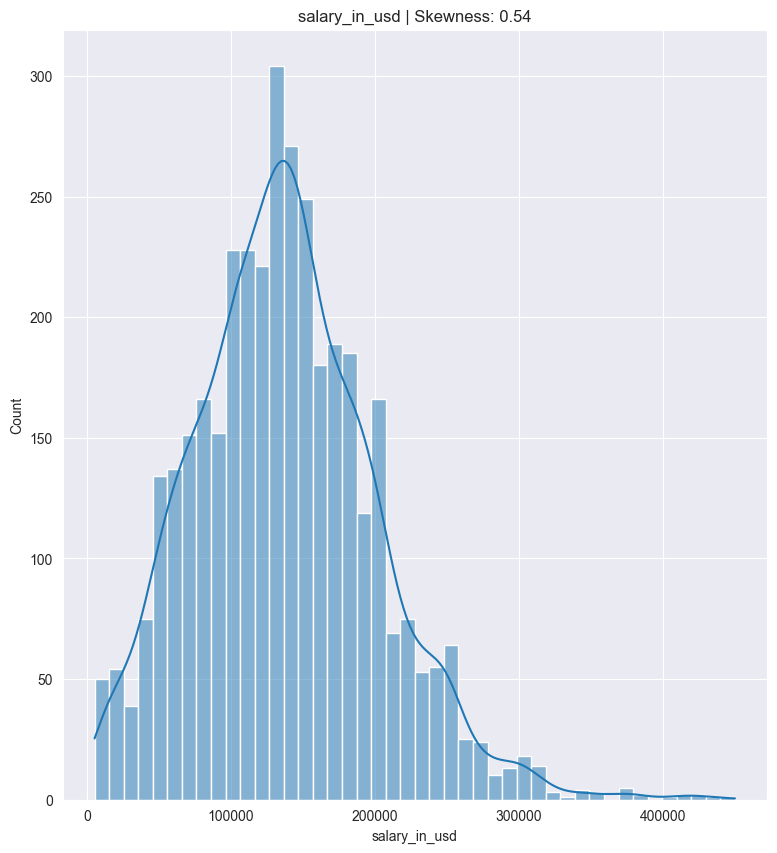

In [329]:
numerical_columns = salaries_data.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(20, 10))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(salaries_data[feature], kde = True)
    plt.title(f"{feature} | Skewness: {round(salaries_data[feature].skew(), 2)}")
    
plt.show()

We can see that the data roughly follows a normal distribution, but there is a slight skewness to it. 

We can also visualize the distribution of the categorical fields along with how the the salary varies with them.

In [330]:
def visualize_categorical_fields(df):
    categorical_columns = df.select_dtypes(include=["category"]).columns
        
    plt.figure(figsize=(15, 30))
    for idx, feature in enumerate(categorical_columns, 1):
        counts = df[feature].value_counts()
        plt.subplot(len(categorical_columns), 2, 2*idx-1)
        plt.bar(counts.index, counts)
        plt.title(f"{feature}")
        
        plt.subplot(len(categorical_columns), 2, 2*idx)
        sns.boxplot(data=df, x=feature, y='salary_in_usd')
        plt.title(f"salary by {feature}")
    
    plt.show()

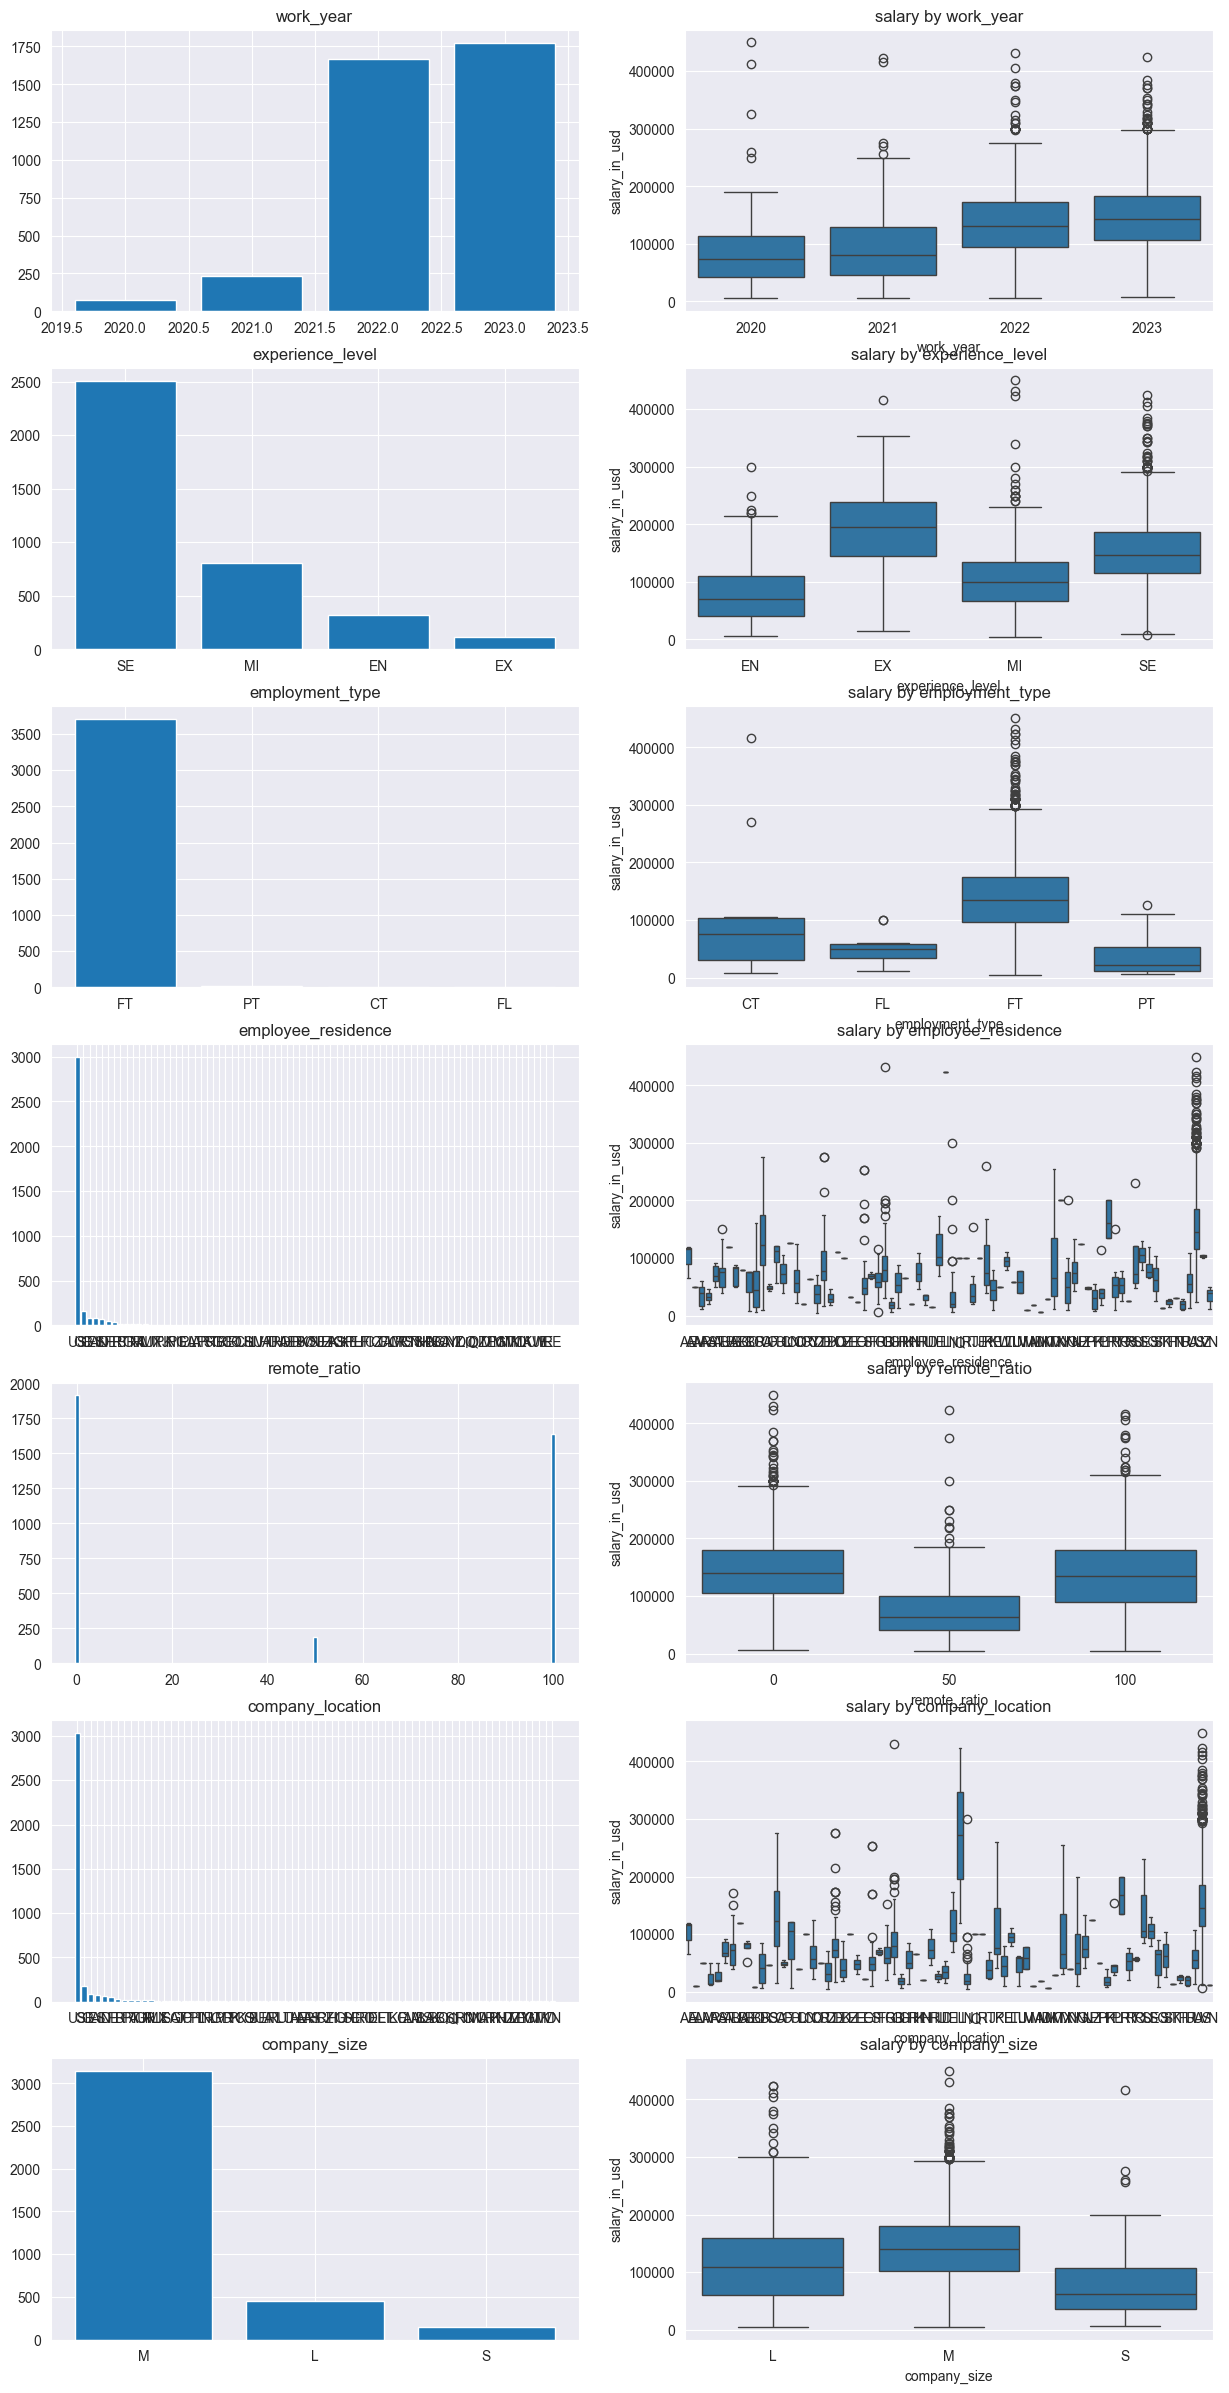

In [331]:
visualize_categorical_fields(salaries_data)

There are several interesting observations here
- We are working with a very imbalanced dataset.
    - Work years `2022` and `2023` are overrepresented
    - `SE` is overrepresented and `EX` is underrepresented in experience level 
    - Most employees are from the `US` (over representation)
    - Most companies are in the `US`(over representation)
    - Remote ratio of `50` (hybrid) is underrepresented
    - `M` (medium) company size is overrepresented in company size
- Salary seems to generally increase with the work year (inflation?)
- Salary seems to increase with experience level in the following order `EN` > `MI` > `SE` > `EX`
- Full time (`FT`) employees are paid the most
- Hybrid employees (remote ratio `50`) seem to be paid the less that fully remote (`0`) and fully in-office (`100`)
- Employees of smaller companies (`S`) are paid slightly less than those of large (`L`) and medium (`M`) companies
- The cardinality of the `employee_residence` and `company_location` fields are too high to make meaningful inferences

The imbalanced dataset will be a significant obstacle with making accurate predictions.

## Feature selection/extraction

We can perform an ANOVA (analysis of variance) to determine how each column affects the salary, and graphically visualize them as a bar chart.

In [332]:
def anova(df, col):
    values = df[col].unique()
    
    filtered_dfs = []
    for value in values:
        df_filter = df[df[col] == value]["salary_in_usd"]
        filtered_dfs.append(df_filter)
        
    f_statistic, p_value = f_oneway(*filtered_dfs)
    
    return f_statistic

Text(0.5, 1.0, 'Analysis of Variance')

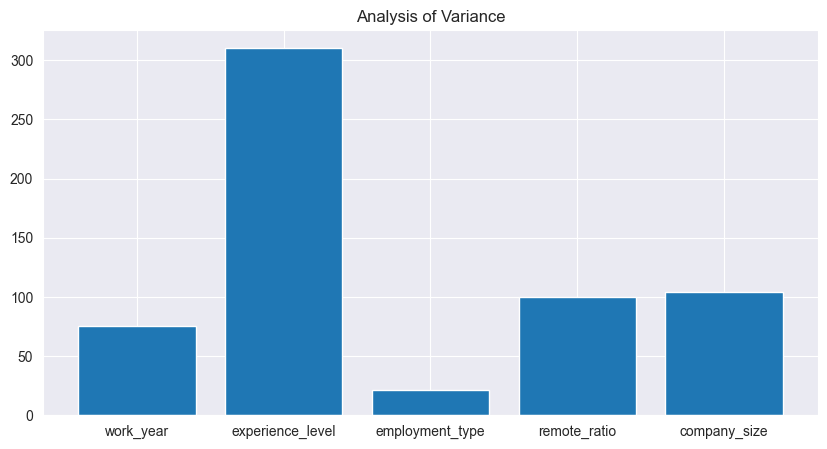

In [333]:
f_work_year = anova(salaries_data, "work_year")
f_experience_level = anova(salaries_data, "experience_level")
f_employment_type = anova(salaries_data, "employment_type")
f_remote_ratio = anova(salaries_data, "remote_ratio")
f_company_size = anova(salaries_data, "company_size")

plt.figure(figsize=(10, 5))
x = np.array(["work_year", "experience_level", "employment_type", "remote_ratio", "company_size"])
y = np.array([f_work_year, f_experience_level, f_employment_type, f_remote_ratio, f_company_size])
plt.bar(x, y)
plt.title("Analysis of Variance")

Here, we can see that the `experience_level` has a large effect on the salary, while the `employment_type` has minimal effect.

It would be an option to drop the `employment_type` field as it would not help out models perform better. 

> Note:
It was decided to not drop this column, as including this column had a minor improvement in the performance of the models.

Another problem we have is the high cardinality of the `company_location` and `employee_residence` columns. We could drop and ignore these columns, but conventional wisdom would indicate that an employee/company's location would have a significant impact on the salary. Therefore, ignoring these fields would result is us losing some valuable information.

As countries have relationships between them, and are not wholly independent, a better option would be to transform this data into something we could work with. Some possible options are as follows
- Replace with the countries with the geographic coordinates (as countries which are closer to each other are more likely to be similar).
- Replace with demographic/economic data (as countries sharing similar demographic/economic realities are more likely to be similar in wages).

After taking a look at freely available data online, it was decided that it would make most sense to replace these two columns with the country's GDP per capita as obtained from the World Bank ([here](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)]).

The data from the world bank was cleaned and the final dataset used can be found [here](https://github.com/kaneeldias/msc-bda-data-mining/blob/master/q1-salaries/data/gdp_per_capita.csv).

In [334]:
gdp_per_capita = pd.read_csv("data/gdp_per_capita.csv")
gdp_per_capita = gdp_per_capita[pd.to_numeric(gdp_per_capita['2020'], errors='coerce').notnull()]
gdp_per_capita = gdp_per_capita[pd.to_numeric(gdp_per_capita['2021'], errors='coerce').notnull()]
gdp_per_capita = gdp_per_capita[pd.to_numeric(gdp_per_capita['2022'], errors='coerce').notnull()]
gdp_per_capita = gdp_per_capita[pd.to_numeric(gdp_per_capita['2023'], errors='coerce').notnull()]
gdp_per_capita.head()

,Country,Code,2020,2021,2022,2023,2024
0,Afghanistan,AF,516.664,356.063,352.456,410.933,no data
1,Lebanon,LB,4410.402,3537.129,4467.189,4486.987,no data
3,Luxembourg,LU,117616.151,134924.978,126597.939,129810.315,135321.424
4,Switzerland,CH,86138.871,93966.493,94798.83,101510.023,106097.643
5,Ireland,IE,86313.772,103775.442,104728.5,103465.935,103500.385


The dataset contains the GDP per capita of every country for the years 2020, 2021, 2022, 2023 and 2024.

In [335]:
gdp_per_capita.dtypes

Country    object
Code       object
2020       object
2021       object
2022       object
2023       object
2024       object
dtype: object

First, we convert each GDP per capita value to floats. 

In [336]:
gdp_per_capita['2020'] = gdp_per_capita["2020"].astype("float64")
gdp_per_capita['2021'] = gdp_per_capita["2021"].astype("float64")
gdp_per_capita['2022'] = gdp_per_capita["2022"].astype("float64")
gdp_per_capita['2023'] = gdp_per_capita["2023"].astype("float64")

gdp_per_capita.dtypes

Country     object
Code        object
2020       float64
2021       float64
2022       float64
2023       float64
2024        object
dtype: object

Next for each row in the salaries dataset, we include two new fields
- residence gdp per capita - The GDP per capita of the employee country of residence
- company residence per capita - The GDP per capita of the company's location

In [337]:
for index, row in salaries_data.iterrows():
    residence_country = row["employee_residence"]
    company_country = row["company_location"]
    year = str(row["work_year"])
    
    residence_gdp_per_capita = gdp_per_capita[gdp_per_capita["Code"] == residence_country]
    company_gdp_per_capita = gdp_per_capita[gdp_per_capita["Code"] == company_country]
    
    salaries_data.loc[index, "residence_gdp_per_capita"] = residence_gdp_per_capita[year].mean(numeric_only=True)
    salaries_data.loc[index, "company_gdp_per_capita"] = company_gdp_per_capita[year].mean(numeric_only=True)

salaries_data.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,residence_gdp_per_capita,company_gdp_per_capita
0,2023,SE,FT,Principal Data Scientist,85847,ES,100,ES,L,33895.593,33895.593
1,2023,MI,CT,ML Engineer,30000,US,100,US,S,82715.100,82715.100
2,2023,MI,CT,ML Engineer,25500,US,100,US,S,82715.100,82715.100
3,2023,SE,FT,Data Scientist,175000,CA,100,CA,M,53607.403,53607.403
4,2023,SE,FT,Data Scientist,120000,CA,100,CA,M,53607.403,53607.403


Now we can drop the `employee_residence` and `company_location` fields as they are redundant.

In [338]:
salaries_data = salaries_data.drop("employee_residence", axis=1)
salaries_data = salaries_data.drop("company_location", axis=1)

We will now visualize the content of the two new columns. 

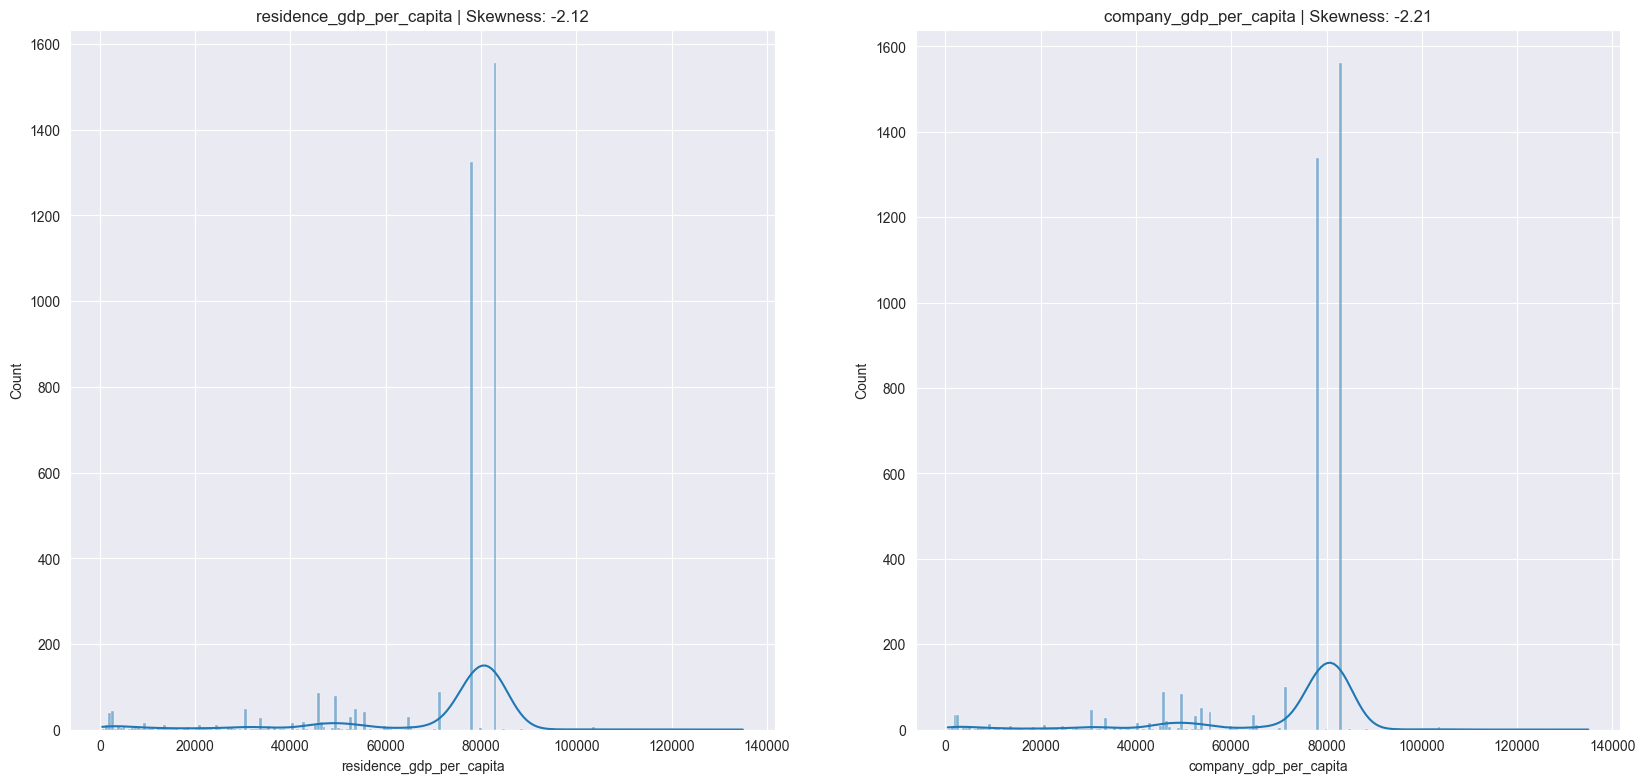

In [339]:
plt.figure(figsize=(20, 20))
for idx, feature in enumerate(["residence_gdp_per_capita", "company_gdp_per_capita"], 1):
    plt.subplot(2, 2, idx)
    sns.histplot(salaries_data[feature], kde = True)
    plt.title(f"{feature} | Skewness: {round(salaries_data[feature].skew(), 2)}")
    
plt.show()

We can see that the two new columns are once again imbalance, which two high peaks around 80,000 USD. This is however expected, as most of the original data was from a single company (`US`).

We can now analyze how these two fields affect the salary but looking at their correllation.

,salary_in_usd,residence_gdp_per_capita,company_gdp_per_capita
salary_in_usd,1.000000,0.498071,0.478054
residence_gdp_per_capita,0.498071,1.000000,0.919419
company_gdp_per_capita,0.478054,0.919419,1.000000


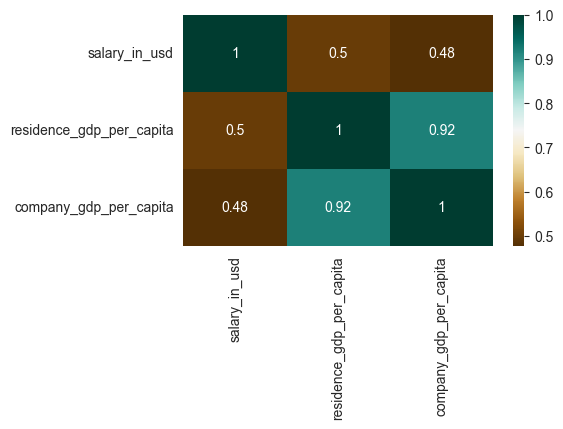

In [340]:
numerical_data = salaries_data.select_dtypes(include=["int64", "float64"])

plt.figure(figsize = (5,3))
c = numerical_data.corr()
sns.heatmap(c, cmap="BrBG", annot=True)
c

We can clearly see that there is a positive correlation between the GDP fields and the salary. This is expected as the GDP per capita is aligned with income in most cases. 

We can now plot the resident/company GDP against the salary for each data point to see whether this pattern holds. 

Text(0.5, 1.0, 'Salary by Company GDP per capita')

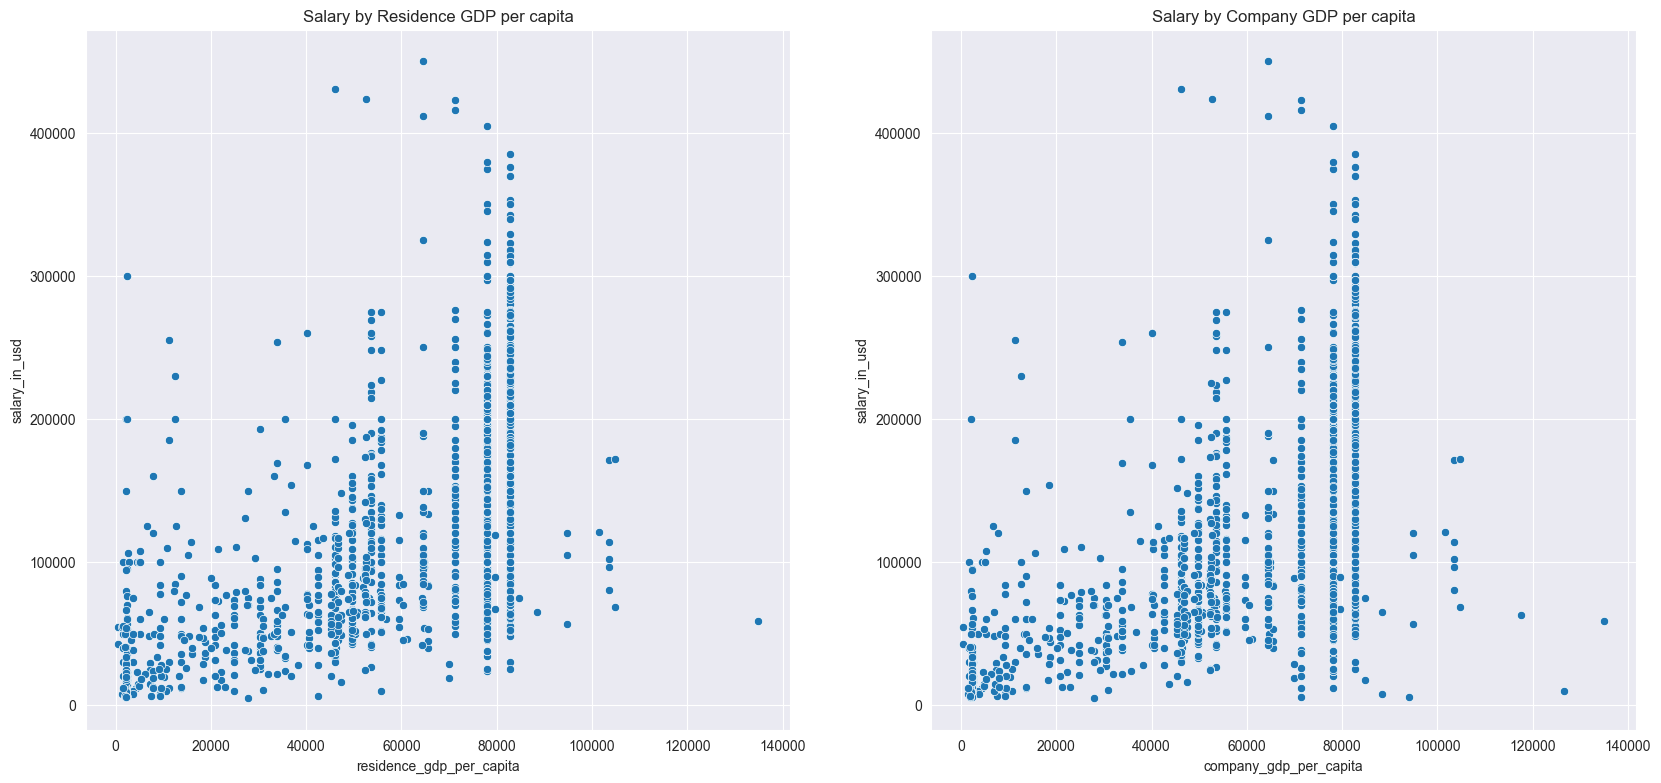

In [341]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
sns.scatterplot(data=salaries_data, x="residence_gdp_per_capita", y="salary_in_usd")
plt.title("Salary by Residence GDP per capita")

plt.subplot(2, 2, 2)
sns.scatterplot(data=salaries_data, x="company_gdp_per_capita", y="salary_in_usd")
plt.title("Salary by Company GDP per capita")

We can see that in general, as the GDP increases, so does the salary

## Outlier detection and removal
We can use an isolation forest using the numerical data fields to detect outliers, and plot them in similar scatter plots. 

In [342]:
iso_forest = IsolationForest(contamination=0.01)
iso_forest.fit(numerical_data)

outliers = iso_forest.predict(numerical_data)

Text(0.5, 1.0, 'Salary by Company GDP per capita')

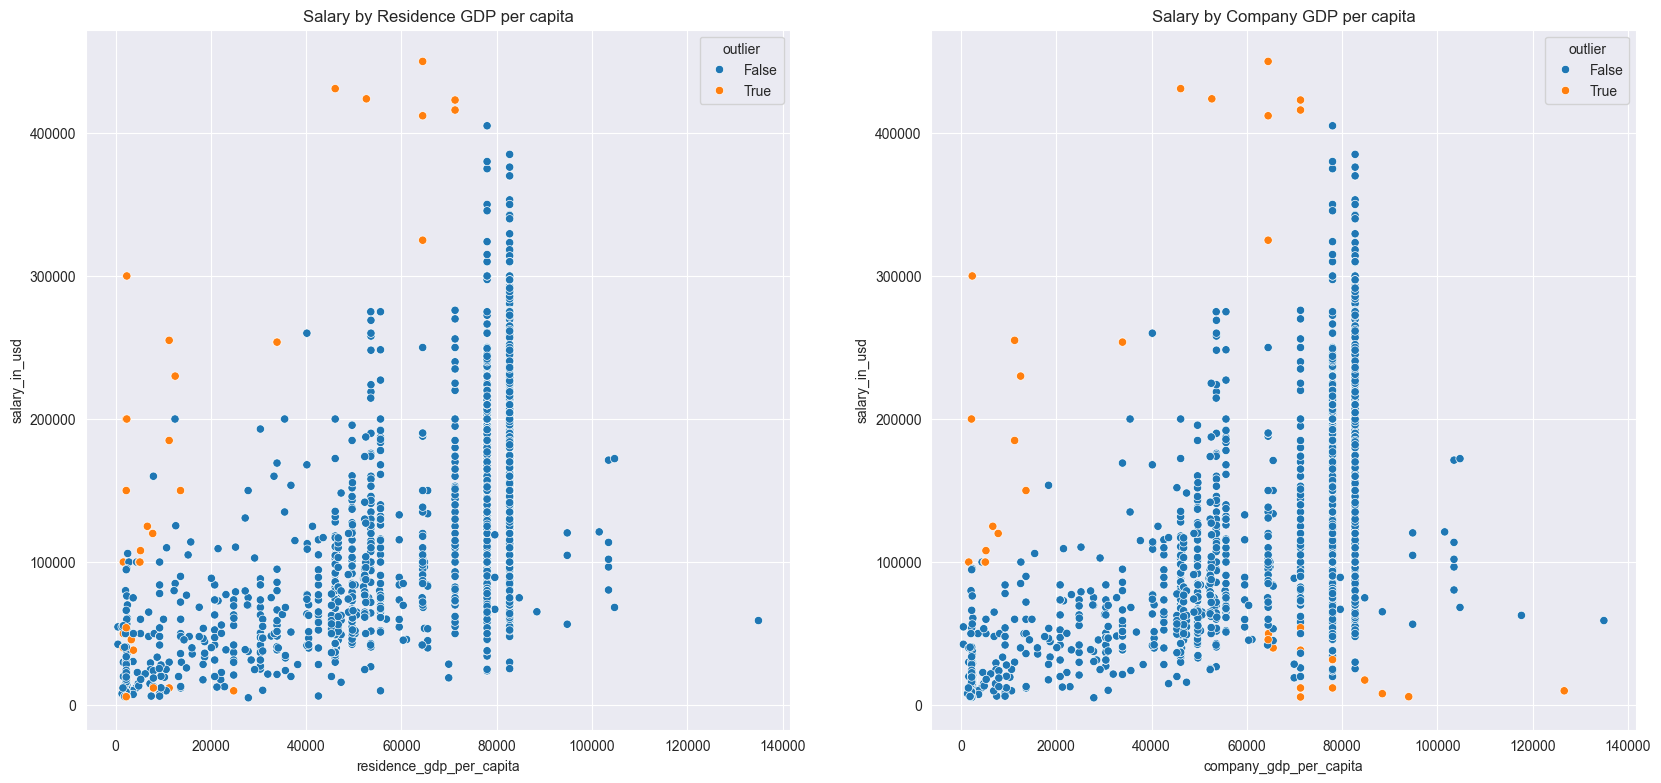

In [343]:
numerical_data["outlier"] = outliers == -1

plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
sns.scatterplot(data=numerical_data, x="residence_gdp_per_capita", y="salary_in_usd", hue="outlier")
plt.title("Salary by Residence GDP per capita")

plt.subplot(2, 2, 2)
sns.scatterplot(data=numerical_data, x="company_gdp_per_capita", y="salary_in_usd", hue="outlier")
plt.title("Salary by Company GDP per capita")



There are a few outliers. We will remove them from the working dataset. 

In [344]:
salaries_data.shape

(3743, 9)

In [345]:
salaries_data = salaries_data[numerical_data["outlier"] == False]
salaries_data.shape

(3705, 9)

After the removal of outliers, we have 3,705 records remaining. Which should me more than sufficient to proceed.

Looking at the dataset, we notice that there are many records where all of the fields are the same, except for the salary. This can be an issue as our model will fail when attempting to predict salaries as for the same input, there can be multiple possible outputs. We will fix this problem by replacing the salary for these duplicate records with their means.

In [346]:
salaries_data = salaries_data.groupby(["work_year", "experience_level", "employment_type", "job_title", "remote_ratio", "residence_gdp_per_capita", "company_gdp_per_capita", "company_size"], observed=True)
salaries_data = salaries_data["salary_in_usd"].mean()
salaries_data = salaries_data.reset_index()
salaries_data.shape

(812, 9)

This reduces our dataset to 816 records

We will save the current cleaned and transformed version of our dataset in case we need to come back to it in the future.

In [347]:
salaries_data.to_csv("data/ds_salaries_cleaned.csv", index=False)

## Pre-processing

### Labelling categorical data
We have several numerical and categorical fields which should be normalized before we use them as inputs for the model.

All the categorical fields (`work_year`, `experience_level`, `employment_type`, `remote_ratio`, `company_size`) have natural ordering (ordinal). Therefore, we can assign labels to these fields in the natural order we encounter.

In [348]:
years_mapping = {
    "2020": 1,
    "2021": 2,
    "2022": 3,
    "2023": 4,
}
years_encoded = salaries_data["work_year"].apply(lambda x: years_mapping[str(x)])
salaries_data["work_year"] = years_encoded
salaries_data["work_year"] = salaries_data.work_year.astype("int32")

In [349]:
experience_levels_mapping = {
    "EN": 1,
    "MI": 2,
    "SE": 3,
    "EX": 4
}
experience_levels_encoded = salaries_data["experience_level"].apply(lambda x: experience_levels_mapping[str(x)])
salaries_data["experience_level"] = experience_levels_encoded
salaries_data["experience_level"] = salaries_data.experience_level.astype("int32")

In [350]:
employment_type_mapping = {
    "PT": 1,
    "FL": 2,
    "CT": 3,
    "FT": 4
}
employment_type_encoded = salaries_data["employment_type"].apply(lambda x: employment_type_mapping[str(x)])
salaries_data["employment_type"] = employment_type_encoded
salaries_data["employment_type"] = salaries_data.employment_type.astype("int32")

In [351]:
remote_ratio_mapping = {
    "0": 1,
    "50": 2,
    "100": 3
}
remote_ratio_encoded = salaries_data["remote_ratio"].apply(lambda x: remote_ratio_mapping[str(x)])
salaries_data["remote_ratio"] = remote_ratio_encoded
salaries_data["remote_ratio"] = salaries_data.remote_ratio.astype("int32")

In [352]:
company_size_mapping = {
    "S": 1,
    "M": 2,
    "L": 3
}
company_size_encoded = salaries_data["company_size"].apply(lambda x: company_size_mapping[str(x)])
salaries_data["company_size"] = company_size_encoded
salaries_data["company_size"] = salaries_data.company_size.astype("int32")

### Normalization
The now numerical data, we can normalize them to values between 0 and 1 using min-max normalization.

In [353]:
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

In [354]:
salaries_data["residence_gdp_per_capita"] = normalize(salaries_data["residence_gdp_per_capita"])
salaries_data["company_gdp_per_capita"] = normalize(salaries_data["company_gdp_per_capita"])
salaries_data["experience_level"] = normalize(salaries_data["experience_level"])
salaries_data["employment_type"] = normalize(salaries_data["employment_type"])
salaries_data["work_year"] = normalize(salaries_data["work_year"])
salaries_data["remote_ratio"] = normalize(salaries_data["remote_ratio"])
salaries_data["company_size"] = normalize(salaries_data["company_size"])

We can see the current working version of our dataset here.

In [355]:
salaries_data.head()

,work_year,experience_level,employment_type,job_title,remote_ratio,residence_gdp_per_capita,company_gdp_per_capita,company_size,salary_in_usd
0,0.0,0.0,0.666667,Business Data Analyst,1.0,0.475775,0.475775,1.0,100000.0
1,0.0,0.0,1.000000,AI Scientist,0.5,0.450587,0.450587,0.0,45896.0
2,0.0,0.0,1.000000,Big Data Engineer,1.0,0.475775,0.475775,1.0,70000.0
3,0.0,0.0,1.000000,Data Analyst,0.0,0.010453,0.010453,0.0,6072.0
4,0.0,0.0,1.000000,Data Analyst,1.0,0.011818,0.011818,0.0,10000.0


For each of the numerical fields, we can determine their correlation with the `salary_in_usd`

In [356]:
numerical = salaries_data.drop("job_title", axis=1)
numerical.corr()["salary_in_usd"]

work_year                   0.186865
experience_level            0.483906
employment_type             0.145029
remote_ratio               -0.082994
residence_gdp_per_capita    0.640931
company_gdp_per_capita      0.631433
company_size                0.050684
salary_in_usd               1.000000
Name: salary_in_usd, dtype: float64


We can see that there is high correlation between the following fields and the salary
- Residence GDP per capita
- Company GDP per capita
- Experience level

This is consistent with our previous findings as well as general intuition. 


## Model 1: Neutral Network using Tensorflow

### Text vectorization and embedding
Machine learning models cannot be directly used with string/text data as computers are unable to understand what each text means (by default). There we need to transform the `job_title` field to something which is machine readable. 

One technique we can use is vectorization and embedding. Tensorflow provides the functionality to do this.

The following block of code is a part of the pre-processing layer, it takes in a string, vectorizes it, performs embedding, and returns a single floating point integer.

In [357]:
vectorize_layer = TextVectorization(
    max_tokens=1000,
    output_mode='int',
    standardize="lower_and_strip_punctuation",
    output_sequence_length=5
)
vectorize_layer.adapt(salaries_data['job_title'].values)

embedding_dim = 1
embedding_layer = Embedding(
    input_dim=100,
    output_dim=embedding_dim
)

# Vectorize and embed the job titles
job_title_input = Input(shape=(1,), dtype=tf.string, name='job_title')
job_title_vectorized = vectorize_layer(job_title_input)
job_title_embedded = embedding_layer(job_title_vectorized)
job_title_branch = GlobalAveragePooling1D()(job_title_embedded)

Since the remaining fields are all numerical, we can pass it to the model without any specific pre-processing.

In [358]:
company_gdp_input = Input(shape=(1,), dtype=tf.float64, name="company_gdp")
residence_gdp_input = Input(shape=(1,), dtype=tf.float64, name="residence_gdp")
experience_level_input = Input(shape=(1,), dtype=tf.float64, name="experience_level")
employment_type_input = Input(shape=(1,), dtype=tf.float64, name="employment_type")
work_year_input = Input(shape=(1,), dtype=tf.float64, name="work_year")
company_size_input = Input(shape=(1,), dtype=tf.float64, name="company_size")
remote_ratio_input = Input(shape=(1,), dtype=tf.float64, name="remote_ratio")

We use a traditional feed forward neural network as the first model. We tuned specific hyperparameters and tested each model to obtain the best result. 

Dropout layers and regularization was used to prevent overfitting. 

The results of the performance turning can be found [here](https://docs.google.com/spreadsheets/d/1_54Z5olTkogpqVpxOxoNmn6htHkwi4s0h6TU3P-PtJw/edit?usp=sharing). 

The best performing neural network is the following.

*Input fields*
- work year
- experience level
- employment type
- company GDP
- residence GDP
- job title
- company size
- remote ratio

*Hidden layers*
- Dense (256, ReLU)
- Dropout (0.5)
- Dense (128, ReLU)
- Dropout (0.5)
- Dense (64, ReLU)
- Output (1)

*Model parameters*
- Learning algorith: Adam
- Learning rate: 0.0005
- Loss function: Mean Squared Error

*Training*
- Epochs: 100
- Batch size: 8

In [359]:
def build_model():
    inputs = [company_gdp_input, residence_gdp_input, experience_level_input, work_year_input, company_size_input, remote_ratio_input]
    include_job_title = True

    preprocessed_layers = []
    for input_layer in inputs:
        preprocessed_layers.append(input_layer)
    
    if include_job_title:
        preprocessed_layers.append(job_title_branch)

    concatenated = concatenate(preprocessed_layers)

    input_layers = []
    for input_layer in inputs:
        input_layers.append(input_layer)
    
    if include_job_title:
        input_layers.append(job_title_input)
    
    regularizer = regularizers.L1L2(l1=0.01, l2=0.01)
    
    hidden_layer_1 = Dense(256, activation='relu', kernel_regularizer=regularizer)(concatenated)
    dropout_1 = Dropout(0.5)(hidden_layer_1)
    hidden_layer_2 = Dense(128, activation='relu', kernel_regularizer=regularizer)(dropout_1)
    dropout_2 = Dropout(0.5)(hidden_layer_2)
    hidden_layer_3 = Dense(64, activation='relu', kernel_regularizer=regularizer)(dropout_2)
    output = Dense(1, activation=None)(hidden_layer_3)
    
    model = tf.keras.Model(inputs=input_layers, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError, metrics=[tf.keras.metrics.RootMeanSquaredError])
    
    return model

The performance of the model was evaluated using 5-fold cross validation. The performance of the model with the epochs as the final validation accuracy can be found below. 

In [360]:
def evaluate_nn(model_builder, df, epochs, batch_size, k=5):
    kf = KFold(n_splits=k, shuffle=True)
    validation_accuracies = []

    for fold, (train_index, val_index) in enumerate(kf.split(df)):
        print(f"Fold {fold + 1}/{k}")
        train_df = df.iloc[train_index]
        val_df = df.iloc[val_index]

        train_work_year = train_df["work_year"]
        train_experience_level = train_df["experience_level"]
        train_employment_type = train_df["employment_type"]
        train_job_title = train_df["job_title"].values
        train_remote_ratio = train_df["remote_ratio"]
        train_residence_gdp_per_capita = train_df["residence_gdp_per_capita"]
        train_company_gdp = train_df["company_gdp_per_capita"]
        train_company_size = train_df["company_size"]
        train_salary = train_df["salary_in_usd"].values

        val_work_year = val_df["work_year"]
        val_experience_level = val_df["experience_level"]
        val_employment_type = val_df["employment_type"]
        val_job_title = val_df["job_title"].values
        val_remote_ratio = val_df["remote_ratio"]
        val_residence_gdp_per_capita = val_df["residence_gdp_per_capita"]
        val_company_gdp = val_df["company_gdp_per_capita"]
        val_company_size = val_df["company_size"]
        val_salary = val_df["salary_in_usd"]

        model = model_builder()

        history = model.fit({
            "work_year": train_work_year,
            "experience_level": train_experience_level,
            "employment_type": train_employment_type,
            "job_title": train_job_title,
            "remote_ratio": train_remote_ratio,
            "residence_gdp": train_residence_gdp_per_capita,
            "company_size": train_company_size,
            "company_gdp": train_company_gdp,
        }, train_salary, epochs=epochs, batch_size=batch_size,
            validation_data=({
                                 "work_year": val_work_year,
                                 "experience_level": val_experience_level,
                                 "employment_type": val_employment_type,
                                 "job_title": val_job_title,
                                 "remote_ratio": val_remote_ratio,
                                 "residence_gdp": val_residence_gdp_per_capita,
                                 "company_size": val_company_size,
                                 "company_gdp": val_company_gdp,
                             }, val_salary), verbose=0)

        # Evaluate the model on the validation set
        _, val_accuracy = model.evaluate({
            "work_year": val_work_year,
            "experience_level": val_experience_level,
            "employment_type": val_employment_type,
            "job_title": val_job_title,
            "remote_ratio": val_remote_ratio,
            "residence_gdp": val_residence_gdp_per_capita,
            "company_size": val_company_size,
            "company_gdp": val_company_gdp,
        }, val_salary, verbose=0)
        validation_accuracies.append(val_accuracy)

        result = pd.DataFrame(history.history)

        result[["root_mean_squared_error", "val_root_mean_squared_error"]].plot(figsize=(5, 3))
        plt.show()

        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print("-" * 20)

    print(f"Average Validation Accuracy: {np.mean(validation_accuracies):.4f}")
    return validation_accuracies

Fold 1/5


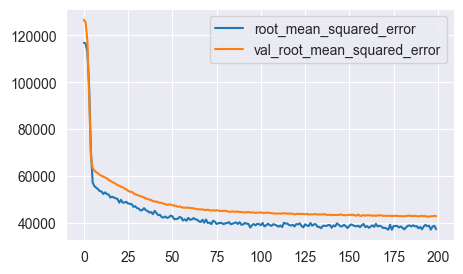

Validation Accuracy: 42989.9023
--------------------
Fold 2/5


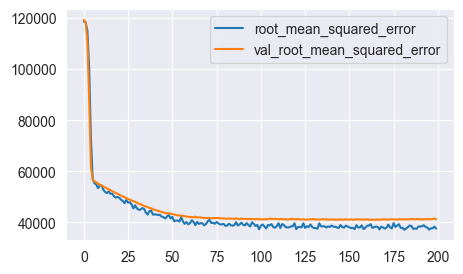

Validation Accuracy: 41212.8477
--------------------
Fold 3/5


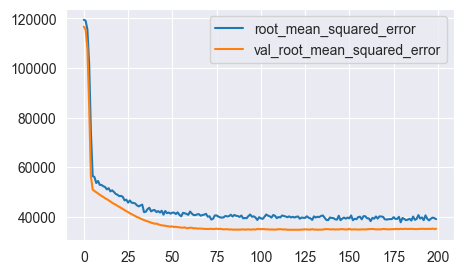

Validation Accuracy: 35177.2109
--------------------
Fold 4/5


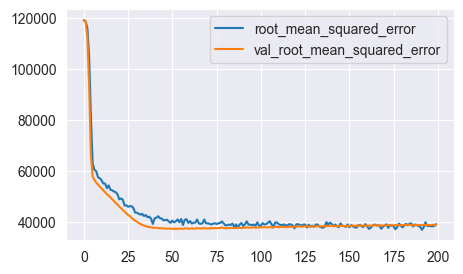

Validation Accuracy: 38732.4062
--------------------
Fold 5/5


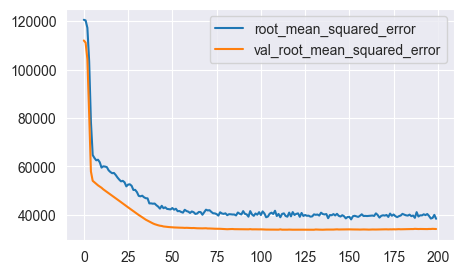

Validation Accuracy: 34169.1797
--------------------
Average Validation Accuracy: 38456.3094


[42989.90234375, 41212.84765625, 35177.2109375, 38732.40625, 34169.1796875]

In [361]:
evaluate_nn(build_model, salaries_data, epochs=200, batch_size=8)

The final validation accuracy was around 38,456.3094 (may vary). The accuracy isn't great, but considering the flaws in the dataset, it was the best model I was able to create.

## Model 2: Random Forest Regressor

### Bag of words
Once again, we cannot use the `job_title` directly as input, and we need to transform it. Another possible option is to use bag of words - which counts the occurrence of each word in the dictionary in each field. 

In [362]:
bag_of_words = []
for job_title in salaries_data["job_title"]:
    job_title = job_title.lower()
    words = job_title.split()
    words = [word.strip('.,!;()[]') for word in words]
    words = [word.replace("'s", '') for word in words]
    words = [word.strip('.,!;()[]') for word in words]
    words = [word.replace("'s", '') for word in words]

    for word in words:
        if word not in bag_of_words:
            bag_of_words.append(word)

In [363]:
for index, row in salaries_data.iterrows():
    job_title = row["job_title"]
    job_title = job_title.lower()
    words = job_title.split()
    
    for word in bag_of_words:
        contains_word = word in words
        salaries_data.loc[index, f"contains_{word}"] = contains_word

This add new columns for each word in the `job_title` column with the format `contains_{word}`. The value of each field is either `True` or `False` corresponding to whether the job title contains this word. 

In [364]:
salaries_data.head()

,work_year,experience_level,employment_type,job_title,remote_ratio,residence_gdp_per_capita,company_gdp_per_capita,company_size,salary_in_usd,contains_business,...,contains_vehicle,contains_technician,contains_compliance,contains_insight,contains_azure,contains_intelligence,contains_devops,contains_modeler,contains_quality,contains_strategist
0,0.0,0.0,0.666667,Business Data Analyst,1.0,0.475775,0.475775,1.0,100000.0,True,...,False,False,False,False,False,False,False,False,False,False
1,0.0,0.0,1.000000,AI Scientist,0.5,0.450587,0.450587,0.0,45896.0,False,...,False,False,False,False,False,False,False,False,False,False
2,0.0,0.0,1.000000,Big Data Engineer,1.0,0.475775,0.475775,1.0,70000.0,False,...,False,False,False,False,False,False,False,False,False,False
3,0.0,0.0,1.000000,Data Analyst,0.0,0.010453,0.010453,0.0,6072.0,False,...,False,False,False,False,False,False,False,False,False,False
4,0.0,0.0,1.000000,Data Analyst,1.0,0.011818,0.011818,0.0,10000.0,False,...,False,False,False,False,False,False,False,False,False,False


We can now drop the `job_title` column as we will no longer require it.

In [365]:
salaries_data = salaries_data.drop("job_title", axis=1)

We create a random forest regression model, and evaluate it using 5-fold cross validation once again. 

We tuned this model once again similar to the neural network model.

In [366]:
def evaluate_rf(df, n_estimators, max_depth, max_leaf_nodes, k=5):    
    kf = KFold(n_splits=k, shuffle=True)
    validation_errors = []
    for fold, (train_index, val_index) in enumerate(kf.split(df)):
        print(f"Fold {fold + 1}/{k}")
        
        train_df = df.iloc[train_index]   
        val_df = df.iloc[val_index]
        
        train_target = train_df["salary_in_usd"]
        train_features = train_df.drop("salary_in_usd", axis=1)
    
        val_target = val_df["salary_in_usd"]
        val_features = val_df.drop("salary_in_usd", axis=1)
        
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
        model.fit(train_features, train_target)
        
        val_pred = model.predict(val_features)
        rmse = float(format(np.sqrt(mean_squared_error(val_target, val_pred))))
        print(f"RMSE: {rmse:.4f}")
        validation_errors.append(rmse)
    
    average_error = np.mean(validation_errors)
    print(f"Validation error:{average_error:.4f}")


In [367]:
evaluate_rf(salaries_data, 200, 200, 200)

Fold 1/5
RMSE: 30516.9065
Fold 2/5
RMSE: 48707.5895
Fold 3/5
RMSE: 39394.3761
Fold 4/5
RMSE: 35844.0741
Fold 5/5
RMSE: 40004.2133
Validation error:38893.4319


The best performance we were able to obtain using this model was 38,967.2031 (may vary). Once again not great, but it was the best which was possible using the dataset.